# Power Price Modeling

Uses ComEd API at https://hourlypricing.comed.com/hp-api/

In [1]:
import urllib.request
import json
import datetime
import numpy
import pytz
import pandas
%matplotlib notebook
import matplotlib.pyplot
import dateutil
import pylab
import scipy.stats
import scipy.optimize
from mpl_toolkits.mplot3d import axes3d

In [2]:
N_priordays=5 #want N_priodays history
Chicago=pytz.timezone("America/Chicago")


In [3]:
def get_prices(startDate,endDate=None):
    '''
    gets data from ComEd
    startDate and endDate should be in YYYYMMDDhhmm
    output is a list of {"1234",5.5}, where "1234" is the UTC in seconds and 5.5 is the price
    '''
    endDate = startDate if endDate is None else endDate
    startDate=Chicago.normalize(Chicago.localize(dateutil.parser.parse(startDate)))
    endDate=Chicago.normalize(Chicago.localize(dateutil.parser.parse(endDate)))
    format="%Y%m%d%H%M"
    startDate=startDate.strftime(format)
    endDate=endDate.strftime(format)
    URL="https://hourlypricing.comed.com/api?type=5minutefeed&datestart=STARTDATE&dateend=ENDDATE&format=text"
    temp=URL.replace("STARTDATE",startDate).replace("ENDDATE",endDate)
    print(temp)
    with urllib.request.urlopen(temp) as response:
        data = response.read().decode('utf-8')
        #print(data)
    out={}
    for obj in data.split(","):
        data=obj.split(":")
        try:
            ts=int(data[0])/1000
            dt=Chicago.normalize(Chicago.localize(datetime.datetime.fromtimestamp(ts)))
            out[dt]=float(data[1])
        except Exception:
            pass
    return out        

In [4]:
startDate="20170901"
endDate="20170910"
startT = 17
endT = 21
#make sure that there are at least N_priordays of data between startDate and endDate
data=get_prices(startDate,endDate)
print(str(len(data.keys()))+" records of data")

https://hourlypricing.comed.com/api?type=5minutefeed&datestart=201709010000&dateend=201709100000&format=text
2583 records of data


In [5]:
def inrange(startT, endT, indatetime):
    '''
    returns true if datetime is between midnight and 5 AM, and a weekday
    '''
    hourflag=(datetime.time(startT,0,0)<=indatetime.time()) and (indatetime.time()<=datetime.time(endT,0,0))
    dayflag=0<=indatetime.weekday()<=4
    return hourflag and dayflag

In [6]:
dates=sorted([dt for dt in data.keys() if inrange(startT, endT, dt)])
print(len(dates))


294


In [7]:
y=[]
A=[]
indices=[]
historical_N=range(1,N_priordays+1)
for dt in dates:
    try:
        price=data[dt]
        prior=dt-datetime.timedelta(minutes=5)
        prior_price=data[prior]
        historical=[dt-datetime.timedelta(days=n) for n in historical_N]
        historical_price=[data[h] for h in historical]
        historical_average=numpy.average(historical_price)
        y.append([price])
        A.append([prior_price,historical_average,1])
        indices.append(dt)
    except Exception:
        #print("in exception with dt="+str(dt))
        pass
A=numpy.matrix(A)
y=numpy.matrix(y)
min(y)

matrix([[-0.5]])

In [8]:
#print("y:\n"+str(y))
#print("A:\n"+str(A))
A_inv=numpy.linalg.pinv(A)
x=numpy.dot(A_inv,y)
Ax=numpy.dot(A,x)
err=y-Ax
print("x:\n"+str(x))
#print("err:\n"+str(err))
print("dim(y): "+str(y.shape))
print("dim(Ax): "+str(Ax.shape))
print("dim(err): "+str(err.shape))
print("dim(indices): "+str(len(indices)))

x:
[[ 0.80926647]
 [ 0.02845041]
 [ 0.36261682]]
dim(y): (147, 1)
dim(Ax): (147, 1)
dim(err): (147, 1)
dim(indices): 147


<IPython.core.display.Javascript object>


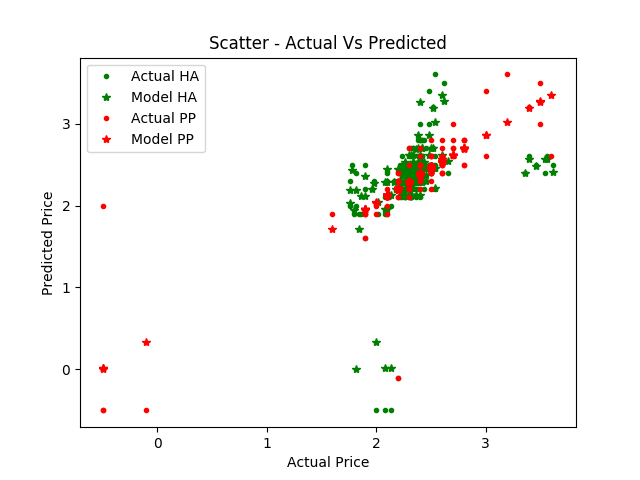

In [12]:
min(Ax)
matplotlib.pyplot.plot(A[:,1],y,'g.')
matplotlib.pyplot.plot(A[:,1],Ax,'g*')

matplotlib.pyplot.plot(A[:,0],y,'r.')
matplotlib.pyplot.plot(A[:,0],Ax,'r*')

matplotlib.pyplot.xlabel('Actual Price')
matplotlib.pyplot.ylabel('Predicted Price')
matplotlib.pyplot.title('Scatter - Actual Vs Predicted')
matplotlib.pyplot.legend(['Actual HA', 'Model HA','Actual PP','Model PP'])
matplotlib.pyplot.savefig('Prediction_vs_Actual')

## Error Modeling

In [14]:
Anew = []
ynew = []
sumval = 0.0
summat = 0.0
for ival in range(len(indices)):
    summat = summat + numpy.abs(numpy.double(A[ival,1]))
    Anew.append([ival+1,summat])
    #Anew.append([1,summat/(ival+1)])
    sumval = sumval + numpy.double(err[ival]*err[ival])
    ynew.append([sumval/(ival+1)])
    #ynew.append([sumval])

Anew=numpy.matrix(Anew)
ynew=numpy.matrix(ynew)    
#sumval
A_inv_new=numpy.linalg.pinv(Anew)
xnew=numpy.dot(A_inv_new,ynew)
Axnew=numpy.dot(Anew,xnew)

x:
[[-0.00483208]
 [ 0.00215658]]


<IPython.core.display.Javascript object>


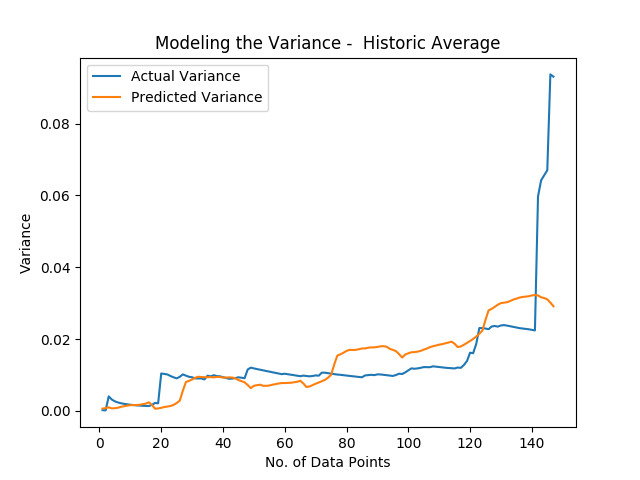

In [17]:
print("x:\n"+str(xnew))

matplotlib.pyplot.plot(range(1,len(indices)+1),ynew)
matplotlib.pyplot.plot(range(1,len(indices)+1),Axnew)
matplotlib.pyplot.xlabel('No. of Data Points')
matplotlib.pyplot.ylabel('Variance')
matplotlib.pyplot.title('Modeling the Variance -  Historic Average')
matplotlib.pyplot.legend(['Actual Variance', 'Predicted Variance'])
matplotlib.pyplot.savefig('Variance_HA')

<IPython.core.display.Javascript object>


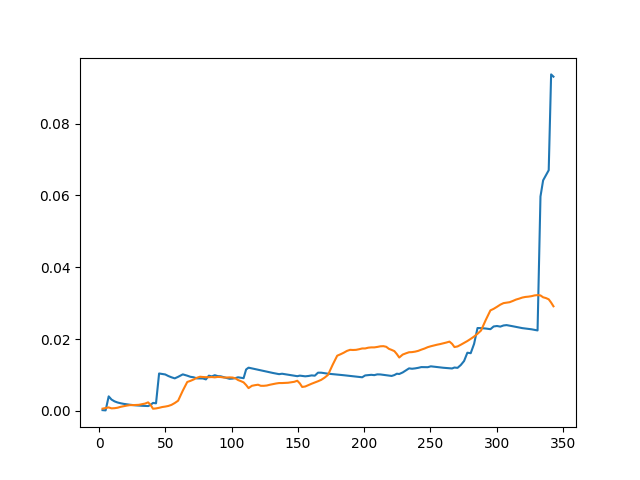

In [18]:
matplotlib.pyplot.plot(Anew[:,1],ynew)
matplotlib.pyplot.plot(Anew[:,1],Axnew)

<IPython.core.display.Javascript object>


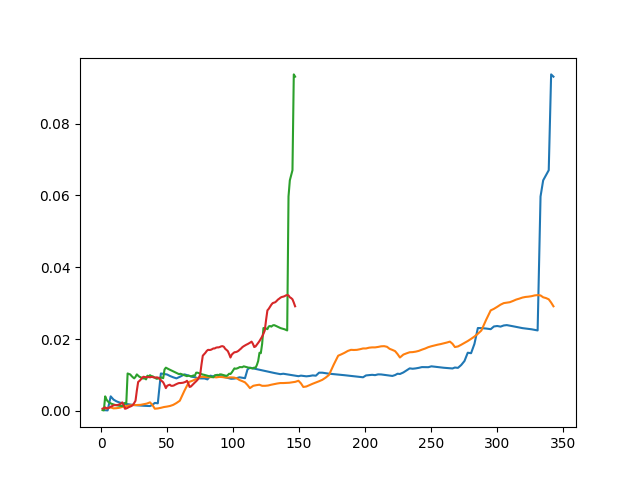

In [19]:
matplotlib.pyplot.plot(Anew[:,1],ynew)
matplotlib.pyplot.plot(Anew[:,1],Axnew)

matplotlib.pyplot.plot(Anew[:,0],ynew)
matplotlib.pyplot.plot(Anew[:,0],Axnew)

<IPython.core.display.Javascript object>


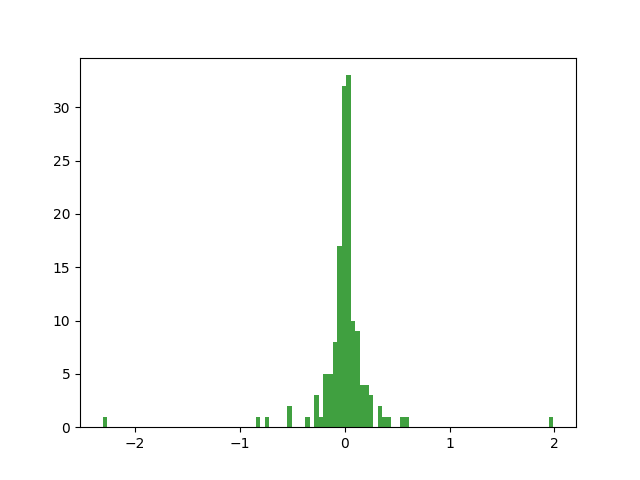

In [20]:
matplotlib.pyplot.hist(err, 100, normed=0, facecolor='green', alpha=0.75)
matplotlib.pyplot.show()


In [ ]:
scipy.stats.probplot(numpy.array(err).flatten(), dist="norm", plot=matplotlib.pyplot)
matplotlib.pyplot.show()

In [ ]:
dateDict={}
timeDict={}
for dt in dates:
    dt_date=dt.date()
    dt_time=dt.time()
    dateDict[dt_date]=True
    timeDict[dt_time]=True
    
for n,t in enumerate(sorted(dateDict.keys())):
    dateDict[t]=n
    
for n,d in enumerate(sorted(timeDict.keys())):
    timeDict[d]=n
    
    
N_times=len(timeDict.keys())
N_days=len(dateDict.keys())
err_matrix=numpy.full([N_days,N_times], numpy.nan)

In [ ]:
for n,dt in enumerate(indices):
    row=dateDict[dt.date()]
    col=timeDict[dt.time()]
    err_matrix[row,col]=err[n]

In [ ]:
acf=numpy.empty(N_times)*numpy.nan
for n in range(N_times):
    M_1=err_matrix[:,:(N_times-n)]
    M_2=err_matrix[:,n:]
    prod=numpy.multiply(M_1,M_2)
    corr=numpy.nanmean(prod)
    acf[n]=corr   

In [ ]:
matplotlib.pyplot.bar(range(N_times),acf,align='center', alpha=0.5)
matplotlib.pyplot.show()

In [ ]:
ERR=numpy.ravel(err)
def loglikelihood(x,y=None):
    if y is None: #one argument; x=(df,scale)
        (df,scale)=x
    else:
        df=x
        scale=y
    temp=scipy.stats.t.pdf(err,df=df,scale=scale)
    return -numpy.average(numpy.log(temp))

loglikelihood_v=numpy.vectorize(loglikelihood)

In [ ]:
N=1

def callback(x):
    global N
    print("N="+str(N)+"; x="+str(x))
    N+=1
    
res=scipy.optimize.minimize(loglikelihood,[3,.001],bounds=[(0,None),(0,None)],callback=callback)
print(res)
(df_est,scale_est)=res.x
print("estimated df="+str(df_est))
print("estimated scale="+str(scale_est))

In [ ]:
df_mesh = numpy.arange(.1,1, 0.005)
scale_mesh = numpy.arange(0.01,.6, 0.01)
df_mesh, scale_mesh = numpy.meshgrid(df_mesh,scale_mesh)
Z = -loglikelihood_v(df_mesh,scale_mesh)

In [ ]:
fig = matplotlib.pyplot.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot a basic wireframe.
ax.plot_wireframe(df_mesh,scale_mesh,Z)
ax.set_xlabel('df')
ax.set_ylabel('scale')
ax.set_zlabel('log likelihood')
matplotlib.pyplot.show()

In [ ]:
df_range = numpy.arange(.1,7,.005)
Z_temp=-loglikelihood_v(df_range,scale_est)
matplotlib.pyplot.plot(df_range,Z_temp)
matplotlib.pyplot.show()

There definitely is a maximum at about 1.5

In [ ]:
n, bins, patches=matplotlib.pyplot.hist(err, 100, normed=True, facecolor='green', alpha=0.75)

mids=(bins[1:]+bins[:-1])/2
widths=bins[1:]-bins[:-1]
t_heights=(scipy.stats.t.cdf(bins[1:],df=df_est,scale=scale_est)-scipy.stats.t.cdf(bins[:-1],df=df_est,scale=scale_est))/widths
matplotlib.pyplot.plot(mids,t_heights,color='red')

std=numpy.std(ERR)
n_heights=(scipy.stats.norm.cdf(bins[1:],scale=std)-scipy.stats.norm.cdf(bins[:-1],scale=std))/widths
matplotlib.pyplot.plot(mids,n_heights,color='blue')

matplotlib.pyplot.show()


It seems that the fat tails make the Gaussian density (blue) wider than it should be.  The t distribution (red) seems much better.

In [ ]:
n, bins, patches=matplotlib.pyplot.hist(err, 100, normed=True, facecolor='green', alpha=0.75)

mids=(bins[1:]+bins[:-1])/2
widths=bins[1:]-bins[:-1]
t_heights=(scipy.stats.t.cdf(bins[1:],df=df_est,scale=scale_est)-scipy.stats.t.cdf(bins[:-1],df=df_est,scale=scale_est))/widths
matplotlib.pyplot.plot(mids,t_heights,color='red')
matplotlib.pyplot.show()

In [ ]:
numpy.savetxt("err.csv", ERR, delimiter=",")
